In [101]:
import torch
from training.FiretraceMLP import FiretraceMLP

checkpoint = torch.load("../models/firetrace_model.pt")

model = FiretraceMLP(width=checkpoint['model_size'][0], depth=checkpoint['model_size'][1])
compiled_model = torch.compile(model, fullgraph=True, mode="max-autotune")

compiled_model.load_state_dict(checkpoint['model_state_dict'])
compiled_model.eval()

OptimizedModule(
  (_orig_mod): FiretraceMLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=10, bias=True)
      (5): ReLU()
      (6): Linear(in_features=10, out_features=10, bias=True)
      (7): ReLU()
      (8): Linear(in_features=10, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=10, bias=True)
      (11): ReLU()
      (12): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)

In [102]:
import pandas as pd

df = pd.read_csv("../data/gen_2/processed/with_fire_area_soi_weather_time.csv")

# Pick last x rows
df = df.tail(500)

y = df["fire_area"]
y = y.reset_index()["fire_area"]
X = df.drop("fire_area", axis=1)

In [103]:
import joblib

x_scaler = joblib.load("../models/x_scaler.save")
y_scaler = joblib.load("../models/y_scaler.save")

x_scaled = x_scaler.transform(X)

In [104]:
print(x_scaled[0].shape)

(9,)


In [105]:
individual_output = compiled_model(torch.tensor(x_scaled[70], dtype=torch.float32).reshape(1, -1))
individual_output_unscaled = y_scaler.inverse_transform(individual_output.detach().numpy().reshape(1, -1))

print("Predicted fire area: ", individual_output_unscaled)

print("Actual fire area: ", y[70])

Predicted fire area:  [[695.4688]]
Actual fire area:  834.72


In [106]:
test_output = compiled_model(torch.tensor(x_scaled, dtype=torch.float32))

test_output

tensor([[0.0454],
        [0.0405],
        [0.0433],
        [0.0442],
        [0.0507],
        [0.0517],
        [0.0561],
        [0.0543],
        [0.0486],
        [0.0598],
        [0.0573],
        [0.0568],
        [0.0551],
        [0.0624],
        [0.0599],
        [0.0596],
        [0.0687],
        [0.0724],
        [0.0752],
        [0.0835],
        [0.0781],
        [0.0761],
        [0.0696],
        [0.0808],
        [0.0802],
        [0.0709],
        [0.0755],
        [0.0699],
        [0.0756],
        [0.0750],
        [0.0872],
        [0.0835],
        [0.0828],
        [0.0734],
        [0.0769],
        [0.0886],
        [0.0876],
        [0.0893],
        [0.0807],
        [0.0944],
        [0.0830],
        [0.0937],
        [0.0904],
        [0.0736],
        [0.0935],
        [0.0787],
        [0.0883],
        [0.0885],
        [0.0725],
        [0.0697],
        [0.0797],
        [0.0851],
        [0.0678],
        [0.0784],
        [0.0765],
        [0

In [107]:
# Unscale the output

y_unscaled = y_scaler.inverse_transform(test_output.detach().numpy())

y_unscaled

array([[ 601.4672  ],
       [ 536.8564  ],
       [ 574.3743  ],
       [ 586.1379  ],
       [ 672.6643  ],
       [ 685.33673 ],
       [ 743.8935  ],
       [ 719.2731  ],
       [ 645.089   ],
       [ 793.111   ],
       [ 760.27325 ],
       [ 753.1299  ],
       [ 731.0991  ],
       [ 827.17505 ],
       [ 794.5793  ],
       [ 790.7408  ],
       [ 911.02893 ],
       [ 959.801   ],
       [ 996.08356 ],
       [1105.9855  ],
       [1035.2938  ],
       [1008.34106 ],
       [ 922.5502  ],
       [1071.4142  ],
       [1062.4375  ],
       [ 939.77313 ],
       [1001.1928  ],
       [ 925.8455  ],
       [1001.5288  ],
       [ 994.6496  ],
       [1155.3423  ],
       [1106.9233  ],
       [1097.8282  ],
       [ 972.2237  ],
       [1018.5811  ],
       [1173.8333  ],
       [1160.5255  ],
       [1183.438   ],
       [1069.716   ],
       [1251.1063  ],
       [1100.1326  ],
       [1242.0732  ],
       [1197.2407  ],
       [ 976.047   ],
       [1238.8167  ],
       [10

In [108]:
# Calculate MAE

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, y_unscaled)

279.4146654095459

Text(0, 0.5, 'Fire Area (sqkm)')

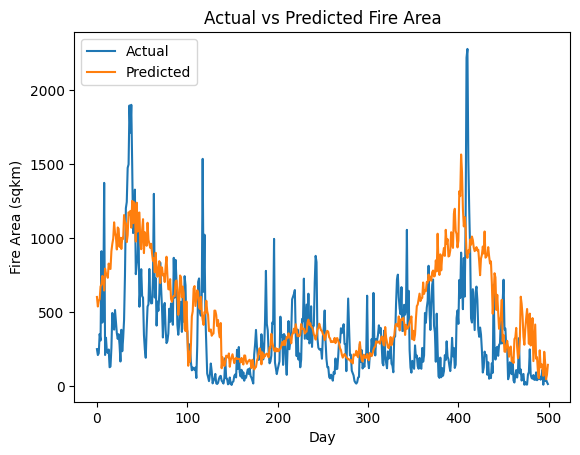

In [109]:
# Graph output vs actual

import matplotlib.pyplot as plt

plt.plot(y, label="Actual")
plt.plot(y_unscaled, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Fire Area")
plt.xlabel("Day")
plt.ylabel("Fire Area (sqkm)")

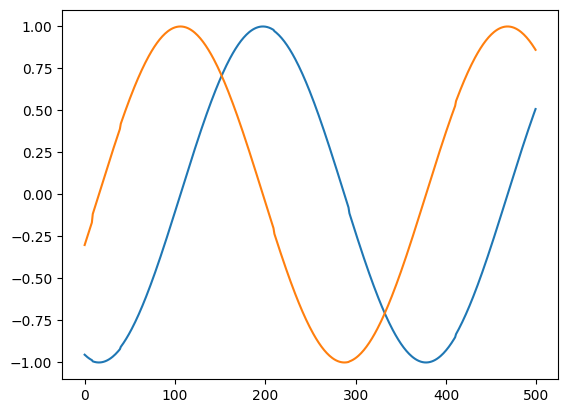

In [110]:
plt.plot(X['sin_signal'].to_numpy())
plt.plot(X['cos_signal'].to_numpy())

